# ARIMA model predicting future stock price

### 0. Load Dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima.utils import nsdiffs
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
from scipy.signal import find_peaks

In [2]:
def plot_line(x, y, x_label = None, y_label = None, title = None):
    plt.figure(figsize=(10, 4))
    plt.plot(x, y, ls = '-')
    plt.xlabel(x_label, fontsize = 13)
    plt.ylabel(y_label, fontsize = 13)
    plt.title(title, fontsize = 15)
    plt.show()

In [3]:
def abs2(x):
    return x.real**2 + x.imag**2

In [4]:
def next_month_end(time):
    if time.month == 12:
        y = time.year + 1
        m = 2
        return datetime(year = time.year + 1, month = 2, day = 1)- timedelta(days = 1)
    elif time.month == 11:
        y = time.year + 1
        m = 1
        return datetime(year = time.year + 1, month = 1, day = 1)- timedelta(days = 1)
    else:
        y = time.year
        m = time.month + 2
    return datetime(year = y, month = m, day = 1) - timedelta(days = 1)

### 1. Load SQLite database

In [5]:
#################################################
# 1. Database Setup
#################################################
engine = create_engine("sqlite:///../data/CompanyData.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# Save reference to the table
MasterData = Base.classes.MasterData
QuintileMonthlyData = Base.classes.QuintileMonthlyData
QuintileAvgData = Base.classes.QuintileAvgData

In [6]:
#################################################
# 2. Tables
#################################################
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Collect the names of tables within the database
print("Table Names: ")
print(inspector.get_table_names())

Table Names: 
['CurrentData', 'FinData2', 'MasterData', 'MasterData_ML', 'PriceData2', 'QuintileAvgData', 'QuintileMonthlyData', 'findata', 'monte_carlo', 'pricedata']


In [7]:
#################################################
# 3. Columns and DataType
#################################################
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('MasterData')
# Column names and DataType
df = pd.DataFrame({"name": [col['name'] for col in columns],
                  "type": [col['type'] for col in columns]})

In [8]:
df.head()

,name,type
0,monthend_date,DATE
1,ticker,VARCHAR(8)
2,price,FLOAT
3,wealth_index,FLOAT
4,end_wealth_index,FLOAT


### 2. Extract price from Individual STOCK

In [9]:
#################################################
# 1. choose stock & query
#################################################
ticker = 'BAC'
session = Session(engine)
results = session.query(MasterData).filter(MasterData.ticker == ticker).all()

In [10]:
date = [res.monthend_date for res in results]
wealth_ind = [res.wealth_index for res in results]
end_wealth_ind = [res.end_wealth_index for res in results]
total_return = [res.total_return for res in results]

df = pd.DataFrame({'date': date, 
                   'wealth_ind': wealth_ind, 
                   'mon_ahead_wealth_ind': end_wealth_ind,
                   'total_return': total_return
                  })
df.head()

,date,wealth_ind,mon_ahead_wealth_ind,total_return
0,2014-11-30,15.7057,16.5374,5.295530
1,2014-12-31,16.5374,14.0045,-15.316192
2,2015-01-31,14.0045,14.6146,4.356457
3,2015-02-28,14.6146,14.2709,-2.351758
4,2015-03-31,14.2709,14.7716,3.508538


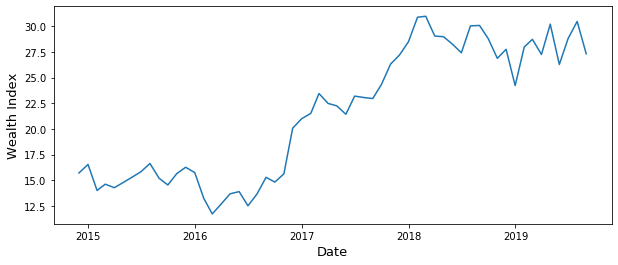

In [11]:
#################################################
# 2. plot raw data
#################################################
plot_line(df.date, df.wealth_ind, 'Date','Wealth Index', None)

## 3. Auto ARIMA -- SARIMA

seasonality: 24


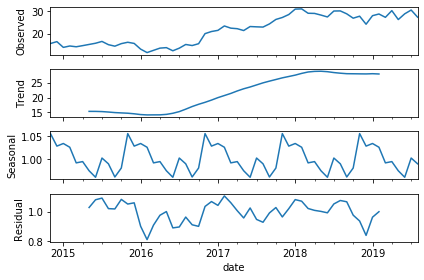

In [12]:
#################################################
# 1. find seasonality
#################################################

data = df.copy()
data = data.set_index('date')
data = data.drop(columns = ['mon_ahead_wealth_ind', 'total_return'])
data.index = pd.to_datetime(data.index)

result = seasonal_decompose(data, model='multiplicative')

# find periodicity in seasonal
seasonal = result.seasonal['wealth_ind']
fft = np.fft.rfft(seasonal, norm="ortho")
selfconvol=np.fft.irfft(abs2(fft), norm="ortho")
x, y = find_peaks(selfconvol, distance=6) 
season = x[1]
print(f'seasonality: {season}')

# plot seasonal decomposition
result.plot()
plt.show()

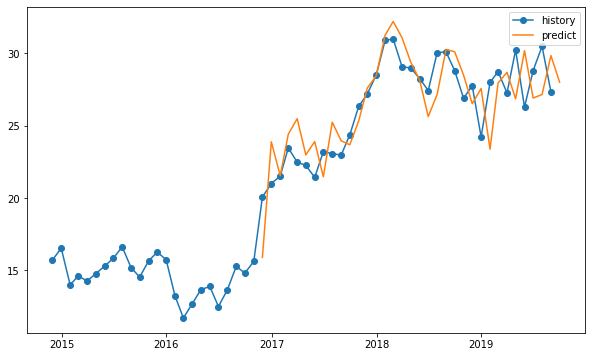

In [13]:
#################################################
# 2. fit Auto_ARIMA with season -- dynamically ARIMA(p, d, q)(P, 12, Q)
#################################################

period = season
history = [data[i: i+period] for i in range(len(data) - period + 1)]

predict = []

for h in history:
    D = nsdiffs(h, m=season, max_D=12, test='ch') # determine seasonal D
    pre_dict = {}
    stepwise_model = pm.auto_arima(h, start_p=1, start_q=1,
                                test='adf',
                        max_p=3, max_q=3, m=season,
                        start_P=0, seasonal=True,
                        d=None, D=D, trace=False,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
    print("ARIMA order: ", stepwise_model.order,stepwise_model.seasonal_order, end = '\r')
    model_fit = stepwise_model.fit(h)
    p = model_fit.predict(n_periods = 1)
    pre_dict['predict_time'] = next_month_end(h.index[-1])
    pre_dict['price'] = p[0]
    predict.append(pre_dict)

#################################################
# 3. plot comparison with historic data
#################################################
predict_time = list(data[period::].index) + list(data.tail(1).index + timedelta(days = 30))
predict_price = [x['price'] for x in predict]
plt.figure(figsize = (10,6))
plt.plot(data,marker = 'o', label = 'history')
plt.plot(predict_time, predict_price, label = 'predict')
plt.legend(loc = 'best')
plt.show()

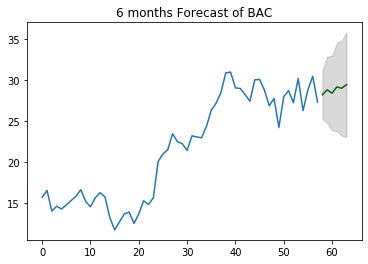

In [14]:
#################################################
# 4. Forcast future 6 months
#################################################
n_periods = 6

D = nsdiffs(h, m=season, max_D=12, test='ch') # determine seasonal D
stepwise_model = pm.auto_arima(data, start_p=1, start_q=1,
                               test='adf',
                               max_p=3, max_q=3, m=season,
                               start_P=0, seasonal=True,
                               d=None, D=D, trace=False,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
print("ARIMA order: ", stepwise_model.order,stepwise_model.seasonal_order, end = '\r')
model_fit = stepwise_model.fit(data)

fc, confint = stepwise_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.wealth_ind), len(df.wealth_ind)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.wealth_ind)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title(f"{n_periods} months Forecast of {ticker}")
plt.show()

Fit ARIMA: order=(1, 1, 1); AIC=691.654, BIC=699.826, Fit time=0.058 seconds
Fit ARIMA: order=(0, 1, 0); AIC=692.345, BIC=696.431, Fit time=0.002 seconds
Fit ARIMA: order=(1, 1, 0); AIC=691.772, BIC=697.901, Fit time=0.024 seconds
Fit ARIMA: order=(0, 1, 1); AIC=691.710, BIC=697.840, Fit time=0.030 seconds
Fit ARIMA: order=(2, 1, 1); AIC=692.783, BIC=702.998, Fit time=0.087 seconds
Fit ARIMA: order=(1, 1, 2); AIC=692.904, BIC=703.120, Fit time=0.110 seconds
Fit ARIMA: order=(2, 1, 2); AIC=695.654, BIC=707.912, Fit time=0.213 seconds
Total fit time: 0.530 seconds

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   57
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -341.827
Method:                       css-mle   S.D. of innovations             95.565
Date:                Mon, 28 Oct 2019   AIC                            691.654
Time:                        01:41:

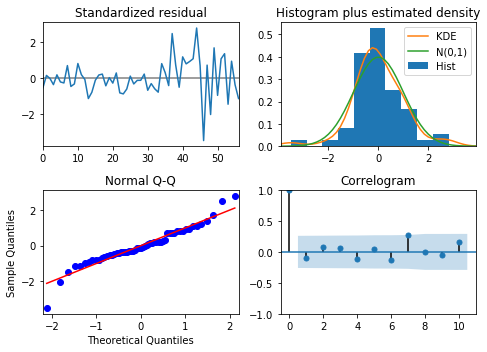

In [16]:
## AUTO ARIMA
model = pm.auto_arima(df.wealth_ind, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=season,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # Include Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print()
print(model.summary())

model.plot_diagnostics(figsize=(7,5))
plt.tight_layout()
plt.show()

## 3.1 Profitable Stratagy?

In [17]:
test_df = df.copy()
test_df.head()

,date,wealth_ind,mon_ahead_wealth_ind,total_return
0,2014-11-30,338.64,310.35,-8.354004
1,2014-12-31,310.35,354.53,14.235541
2,2015-01-31,354.53,380.16,7.229289
3,2015-02-28,380.16,372.10,-2.120160
4,2015-03-31,372.10,421.78,13.351250


#### 1. If invest as nobrainer -- always buy

In [18]:
rise = np.log((test_df['total_return'])/100).fillna(0)
drop = -np.log(-(test_df['total_return'])/100).fillna(0)
sum(drop + rise)

-19.639104187941182

## 4. ARIMA individual parameter check

1 1 1


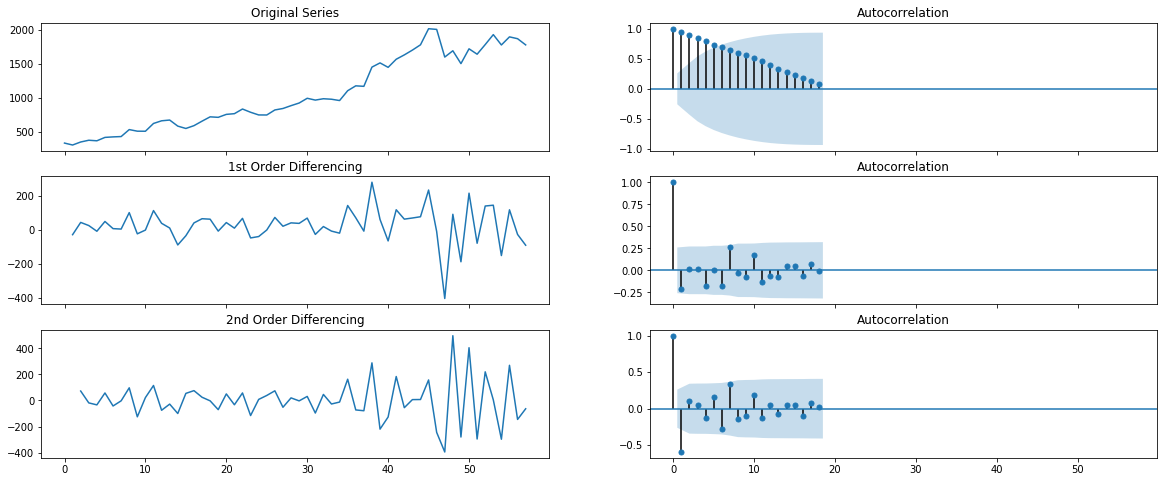

In [19]:
#################################################
# 1. Diff term: d
#################################################
# suggested "d"
y = df.wealth_ind
print(ndiffs(y, test='adf'), ndiffs(y, test='kpss'), ndiffs(y, test='pp')) 

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True, figsize = (20, 8))
axes[0, 0].plot(df.wealth_ind); axes[0, 0].set_title('Original Series')
plot_acf(df.wealth_ind, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.wealth_ind.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.wealth_ind.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.wealth_ind.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.wealth_ind.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

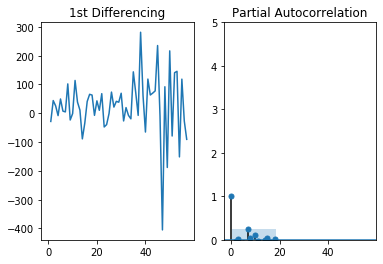

In [20]:
#################################################
# 2. AM term: p 
#################################################
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.wealth_ind.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.wealth_ind.diff().dropna(), ax=axes[1])

plt.show()

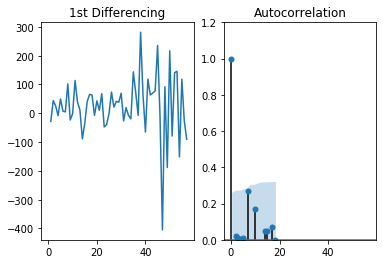

In [21]:
#################################################
# 3. MA term: q
#################################################
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.wealth_ind.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.wealth_ind.diff().dropna(), ax=axes[1])

plt.show()

In [22]:
#################################################
# 4. build ARIMA model (1, 1, 1)
#################################################
model = ARIMA(df.wealth_ind, (1,1,1))
model_fit = model.fit(disp = 0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.wealth_ind   No. Observations:                   57
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -341.827
Method:                       css-mle   S.D. of innovations             95.565
Date:                Mon, 28 Oct 2019   AIC                            691.654
Time:                        01:41:29   BIC                            699.826
Sample:                             1   HQIC                           694.830
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 28.7052      2.952      9.723      0.000      22.919      34.492
ar.L1.D.wealth_ind     0.7819      0.092      8.530      0.000       0.602       0.962
ma.L1.D.wealth_ind  

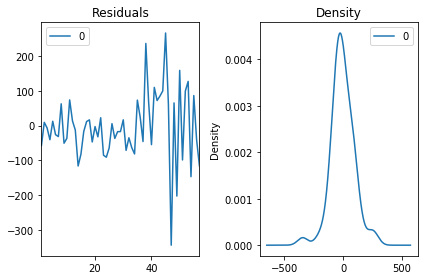

In [23]:
#################################################
# 5. plot residual
#################################################
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()
plt.show()

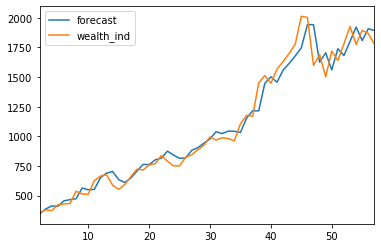

In [24]:
model_fit.plot_predict(dynamic=False)
plt.show()